In this tutorial, we solve a nonlinear elasticity problem using the Fourier-Galerkin method implemented in the `xpektra` library. We use hyperelastic material models to define the stress-strain relationship. The problem is solved using a Newton-Krylov solver with a conjugate gradient method as the linear solver.

In [11]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
from jax import Array

import numpy as np

In [20]:
from xpektra import SpectralSpace, make_field
from xpektra.transform import FFTTransform
from xpektra.scheme import RotatedDifference
from xpektra.spectral_operator import SpectralOperator
from xpektra.projection_operator import GalerkinProjection

from xpektra.solvers.nonlinear import (  # noqa: E402
    NewtonSolver,
    conjugate_gradient,
)

from functools import partial
import equinox as eqx
import matplotlib.pyplot as plt 

## constructing a dual phase RVE

We define a dual-phase RVE with a square inclusion in a square matrix. The inclusion has different material properties than the matrix.

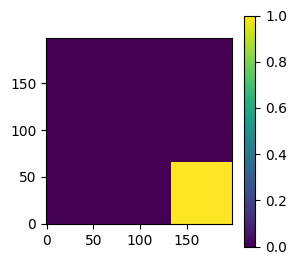

In [13]:
ndim = 2
N = 199
length = 1.0

r = int(N / 3)

structure = np.zeros((N, N))
structure[:r, -r:] +=  np.ones((r, r))

plt.figure(figsize=(3, 3))
cb = plt.imshow(structure, origin="lower")
plt.colorbar(cb)
plt.show()

In [14]:
fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(
    lengths=(length,) * ndim, shape=structure.shape, transform=fft_transform
)
rotated_scheme = RotatedDifference(space=space)

op = SpectralOperator(
    scheme=rotated_scheme,
    space=space,
)

Ghat = GalerkinProjection(scheme=rotated_scheme)
dofs_shape = make_field(dim=ndim, shape=structure.shape, rank=2).shape

In [15]:
E1 = 0.57
E2 = 5.7   
nu1 = 0.386
nu2 = 0.386

lambda1 = E1 * nu1 / ((1 + nu1) * (1 - 2 * nu1))
mu1 = E1 / (2 * (1 + nu1))

lambda2 = E2 * nu2 / ((1 + nu2) * (1 - 2 * nu2))
mu2 = E2 / (2 * (1 + nu2))


lambdas = lambda1 * (1.0 - structure) + lambda2 * structure
mus = mu1 * (1.0 - structure) + mu2 * structure

In [16]:
i = jnp.eye(ndim)
I = make_field(dim=ndim, shape=structure.shape, rank=2) + i

@eqx.filter_jit
def green_lagrange_strain(F: Array) -> Array:
    return 0.5 * (op.dot(op.trans(F), F) - I)


@eqx.filter_jit
def strain_energy(F_flat: Array) -> float:
    F = F_flat.reshape(dofs_shape)
    E = green_lagrange_strain(F)
    E = 0.5 * (E + op.trans(E))
    energy = 0.5 * jnp.multiply(lambdas, op.trace(E) ** 2) + jnp.multiply(
        mus, op.trace(op.dot(E, E))
    )
    return energy.sum()


compute_stress = jax.jacrev(strain_energy)


In [ ]:
@eqx.filter_jit
def residual_fn(eps_fluc_flat: Array, macro_strain: float) -> Array:
    """
    A function that computes the residual of the problem based on the given macro strain.
    It takes only the flattened vector of fluctuation strain and a macro strain.

    Args:
        eps_fluc_flat: Flattened vector of fluctuation strain.
        macro_strain: Macro strain.

    Returns:
        Residual field.
    """

    eps_fluc = eps_fluc_flat.reshape(dofs_shape)
    eps_macro = jnp.zeros(dofs_shape)
    eps_macro = eps_macro.at[:, :, 0, 0].set(macro_strain)
    eps_macro = eps_macro.at[:, :, 1, 1].set(macro_strain)
    eps_total = eps_fluc + eps_macro
    eps_flat = eps_total.reshape(-1)
    sigma = compute_stress(eps_flat)
    residual_field = op.inverse(Ghat.project(op.forward(sigma.reshape(dofs_shape))))
    return jnp.real(residual_field).reshape(-1)

@eqx.filter_jit
def jacobian_fn(deps_fluc_flat: Array, eps_fluc_flat: Array) -> Array:

    deps_flat = deps_fluc_flat.reshape(-1)
    eps_fluc = eps_fluc_flat.reshape(-1)
    dsigma = jax.jvp(compute_stress, (eps_fluc,), (deps_flat,))[1]
    jvp_field = op.inverse(
        Ghat.project(op.forward(dsigma.reshape(dofs_shape)))
    )
    return jnp.real(jvp_field).reshape(-1)
    



In [18]:
solver = NewtonSolver(
    tol=1e-8,
    max_iter=20,
    krylov_solver=conjugate_gradient,
    krylov_tol=1e-8,
    krylov_max_iter=20,
)

In [22]:
#F = make_field(dim=ndim, shape=structure.shape, rank=2)
#F[:, :, 0, 0] = 1
#F[:, :, 1, 1] = 1

#residual_fn = Residual(Ghat=Ghat, dofs_shape=F.shape)
#jacobian_fn = Jacobian(Ghat=Ghat, dofs_shape=F.shape)


#dF = make_field(dim=ndim, shape=structure.shape, rank=2)

applied_strains = jnp.diff(jnp.linspace(0, 0.01, num=3))
F_fluc_init = jnp.array(make_field(dim=ndim, shape=structure.shape, rank=2))
F_fluc_init = F_fluc_init.at[:, :, 0, 0].set(1.0)
F_fluc_init = F_fluc_init.at[:, :, 1, 1].set(1.0)


for inc, macro_defo in enumerate(applied_strains):
    # solving for elasticity
    #dF[:, :, 0, 1] = dF_avg
    residual = jax.jit(partial(residual_fn, macro_strain=macro_defo))
    jacobian = jax.jit(partial(jacobian_fn, eps_fluc_flat=F_fluc_init.reshape(-1)))
    
    #b = -jacobian_fn(dF.reshape(-1), F.reshape(-1))
    #F = F + dF
    b = -residual(F_fluc_init.reshape(-1))

    #jacobian_partial = eqx.Partial(jacobian_fn, eps_flat=F.reshape(-1))

    dF_fluc = solver.solve(
        x=F_fluc_init.reshape(-1),
        b=b,
        f=residual,
        jac=jacobian,
    )

    F_fluc = F_fluc_init + dF_fluc.reshape(dofs_shape)
    F_fluc_init = F_fluc

    F = F_fluc + jnp.eye(ndim)[None, None, :, :] * ( macro_defo)


    """
    final_state = newton_krylov_solver(
        state=(dF, b, F),
        gradient=residual_fn,
        jacobian=jacobian_partial,
        tol=1e-6,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-6,
        krylov_max_iter=20,
    )
    F = final_state[2]
    """



P = compute_stress(F.reshape(-1)).reshape(dofs_shape)


Converged, Residual value : 8.462474426691716e-09
step 0 time 0
Didnot converge, Residual value : 65.24977258511187
step 1 time 1


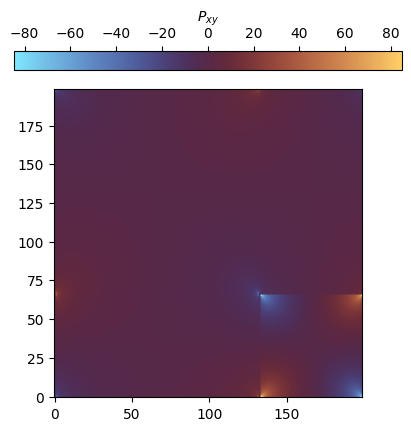

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
cax = ax.imshow(P.at[:, :, 0, 1].get(), cmap="managua_r", origin="lower")
fig.colorbar(cax, label=r"$P_{xy}$", orientation="horizontal", location="top")
plt.show()
